In [1]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import xgcm
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 16

from osse import *
from canyon_utils import *
from sloped_MITgcm import *

import warnings
warnings.filterwarnings('ignore', '.*.')

div_cmap = plt.get_cmap('RdBu_r')
div_cmap.set_bad(color=(0.8,0.8,0.8))

cmap = plt.get_cmap('viridis')
cmap.set_bad(color=(0.8,0.8,0.8))

### Physical parameters

In [2]:
Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = 5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.
delta_t = 15.

### Load dataset

In [3]:
data_dir = "../../MITgcm/experiments/rotated_BBTRE_canyon-tracer/run/"
ds = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=["standardDiag"], delta_t=delta_t)
print(f"Δt = {(ds['time'][-1] - ds['time'][0]).values*1e-9/(24*60*60)} days")
ds = ds.isel(time=-1)
ds, grid = add_rotated_coords(ds, θ)
ds = add_thalweg(ds)
ds = add_background_temp(ds, Γ)

Δt = 450 nanoseconds days


In [4]:
ds = add_hab_coordinates(ds, grid, vert_coord='Zl', gridface='C')
ds['Nsq'] = -g/ρ0*ds['DRHODR'].where(ds['DRHODR']!=0.)+g*α*Γ
ds['Nsq_hab'] = hab_interp(ds['Nsq'], vert_coord='Zl')
ds['Nsq_hab_av'] = ds['Nsq_hab'].mean(['XC', 'YC'], skipna=True).compute()

In [5]:
ds = add_hab_coordinates(ds, grid, vert_coord='Z', gridface='C')
ds['THETA_BG_hab'] = hab_interp(ds['THETA_BG'], vert_coord='Z')

##### high kappa

In [6]:
data_dir = "../../MITgcm/experiments/rotated_BBTRE_canyon-tracer-2xkappa/run/"
ds2 = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=["standardDiag"], delta_t=delta_t)
print(f"Δt = {(ds2['time'][-1] - ds2['time'][0]).values*1e-9/(24*60*60)} days")
ds2 = ds2.isel(time=-1)
ds2, _ = add_rotated_coords(ds2, θ)
ds2 = add_thalweg(ds2)
ds2 = add_background_temp(ds2, Γ)

Δt = 400 nanoseconds days


In [7]:
ds2 = add_hab_coordinates(ds2, grid, vert_coord='Zl', gridface='C')
ds2['Nsq'] = -g/ρ0*ds2['DRHODR'].where(ds['DRHODR']!=0.)+g*α*Γ
ds2['Nsq_hab'] = hab_interp(ds2['Nsq'], vert_coord='Zl')
ds2['Nsq_hab_av'] = ds2['Nsq_hab'].mean(['XC', 'YC'], skipna=True).compute()

### Load bathymetry and hydrography

In [8]:
geo_XY = xr.open_dataset("../../MITgcm/experiments/rotated_BBTRE_canyon/input/geocoords.nc").drop(["X", "Y"])
bathy = xr.open_dataset("../../data/Tozer2019_bathymetry.nc")

cdf = pd.read_csv("../../data/BBTRE_hydrography_hab-binned.csv")

In [9]:
cdf.head()

,Unnamed: 0,cast number,in canyon,bottom pressure,latitude,longitude,pressure above bottom,salinity,temperature,sigma4,pressure_f above bottom,Nsq
0,0,10,True,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,1,10,True,5233.94,-21.784167,-19.4215,50.0,34.735386,1.037667,45.882365,50.0,-1.764905e-08
2,2,10,True,5233.94,-21.784167,-19.4215,100.0,34.735533,1.032737,45.882458,100.0,1.805634e-08
3,3,10,True,5233.94,-21.784167,-19.4215,150.0,34.735648,1.027077,45.882363,150.0,5.291008e-09
4,4,10,True,5233.94,-21.784167,-19.4215,200.0,34.735743,1.022126,45.882335,200.0,4.196493e-08


## Load Thurnherr's microstructure profile categorization

In [10]:
df = pd.read_csv("../../data/BBTRE_Stations_with_classification/1996_BBTRE_1/STATIONS.annot", dtype=str, header=19)
lines = []
for i in range(df.size):
    line = [np.float(e.strip(' ')) for e in str(df.iloc[i].values[0]).replace("\t", " ").split(" ") if len(e.strip(" "))>0]
    lines.append(line)
ndf_96 = pd.DataFrame(lines, columns=["castnum", "latitude", "longitude", "bottom pres", "bottom dep", "max depth", "canyon", "SeaBeam"])
ndf_96["year"] = 1996
ndf_96.head()

,castnum,latitude,longitude,bottom pres,bottom dep,max depth,canyon,SeaBeam,year
0,1.0,-24.9805,-38.5352,NaN,NaN,969.923,NaN,NaN,1996
1,2.0,-25.0020,-38.1853,3975.49,3913.259987,3837.170,NaN,NaN,1996
2,3.0,-25.0028,-38.1848,3974.29,3912.089196,3883.520,NaN,NaN,1996
3,4.0,-25.0013,-38.1855,3973.99,3911.796967,3883.520,NaN,NaN,1996
4,5.0,-25.0007,-38.1858,3973.18,3911.006993,3896.690,NaN,NaN,1996


In [11]:
df = pd.read_csv("../../data/BBTRE_Stations_with_classification/1997_BBTRE_2/STATIONS.annot", dtype=str, header=19)
lines = []
for i in range(df.size):
    line = [np.float(e.strip(' ')) for e in str(df.iloc[i].values[0]).replace("\t", " ").split(" ") if len(e.strip(" "))>0]
    lines.append(line)
ndf = pd.DataFrame(lines, columns=["castnum", "latitude", "longitude", "bottom pres", "bottom dep", "max depth", "canyon", "SeaBeam"])
ndf.head()
ndf["year"] = 1997

In [12]:
ndf = pd.concat([ndf_96, ndf])

## Load microstructure data

In [13]:
mds_list = [xr.open_dataset(f"../../data/BBTRE{year}_microstructure_full.nc") for year in ["96", "97"]]
mds = xr.concat(mds_list, dim="year")
mds = mds.assign_coords({"year": [1996, 1997],})

In [14]:
bins = xr.DataArray(np.arange(2000., 0., -1.), (np.arange(2000., 0., -1.),) , dims="hab")
mds["DEPTH_hab"] = mds["BOT_DEPTH"] - mds["DEPTH"]
mds = mds.assign_coords({"DEPTH_hab":mds["DEPTH_hab"]})

def _interp(x, y, bins=None):
    return np.interp(
        bins,
        x[::-1],
        y[::-1]
    )

def _hab_interp(da):
    da_itp = xr.apply_ufunc(
        _interp,
        da["DEPTH_hab"],
        da,
        vectorize=True,
        dask='parallelized',
        input_core_dims=[["DEPTH"], ["DEPTH"]],
        output_core_dims=[["hab"]],
        output_sizes={"hab": bins.size},
        output_dtypes=[float],
        kwargs={'bins': bins.values},
    )
    da_itp = da_itp.assign_coords({"hab": bins})
    return da_itp

In [15]:
mds["σ4_hab"] = _hab_interp(mds["σ4"])

In [16]:
mds['Nsq_hab'] = -g/ρ0*mds['σ4_hab'].diff("hab")/mds['hab'].diff("hab")
mds['Nsq_hab'] = mds['Nsq_hab'].where(mds['Nsq_hab']!=0.).compute()
mds = mds.coarsen({"hab":25}, "trim").mean(skipna=True).compute()

(1e-08, 1e-05)

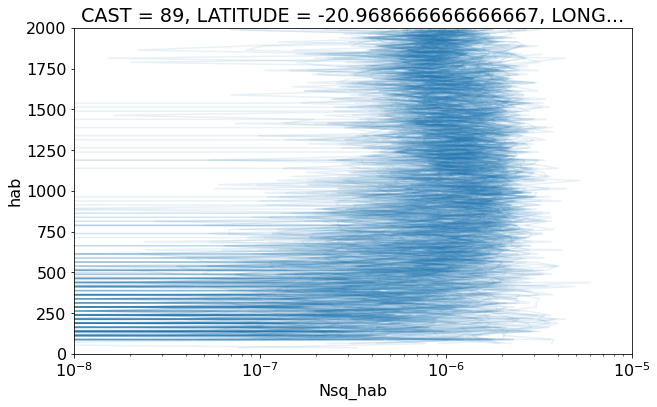

In [17]:
for i in mds["CAST"].values:
    for year in mds["year"].values:
        mds['Nsq_hab'].sel(CAST=i, year=year).plot(y="hab", linestyle="-", color="C0", alpha=0.1)
mds_av = mds['Nsq_hab'].mean("CAST", skipna=True)
mds_std = mds['Nsq_hab'].std("CAST", skipna=True)

plt.ylim([0, 2000])
plt.xscale("log")
plt.xlim(1e-8, 1.e-5)

Text(0.5, 1.0, 'sample-averaged height-above-bottom stratification')

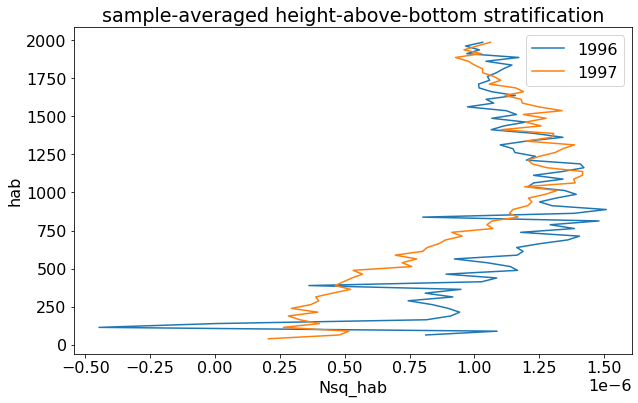

In [18]:
mds_av.sel(year=1996).plot(y="hab", label="1996")
mds_av.sel(year=1997).plot(y="hab", label="1997")
plt.legend()
plt.title("sample-averaged height-above-bottom stratification")

# Map of hydrographic and microstructure profiles

Colored by whether Thurnherr classified as "in-canyon".

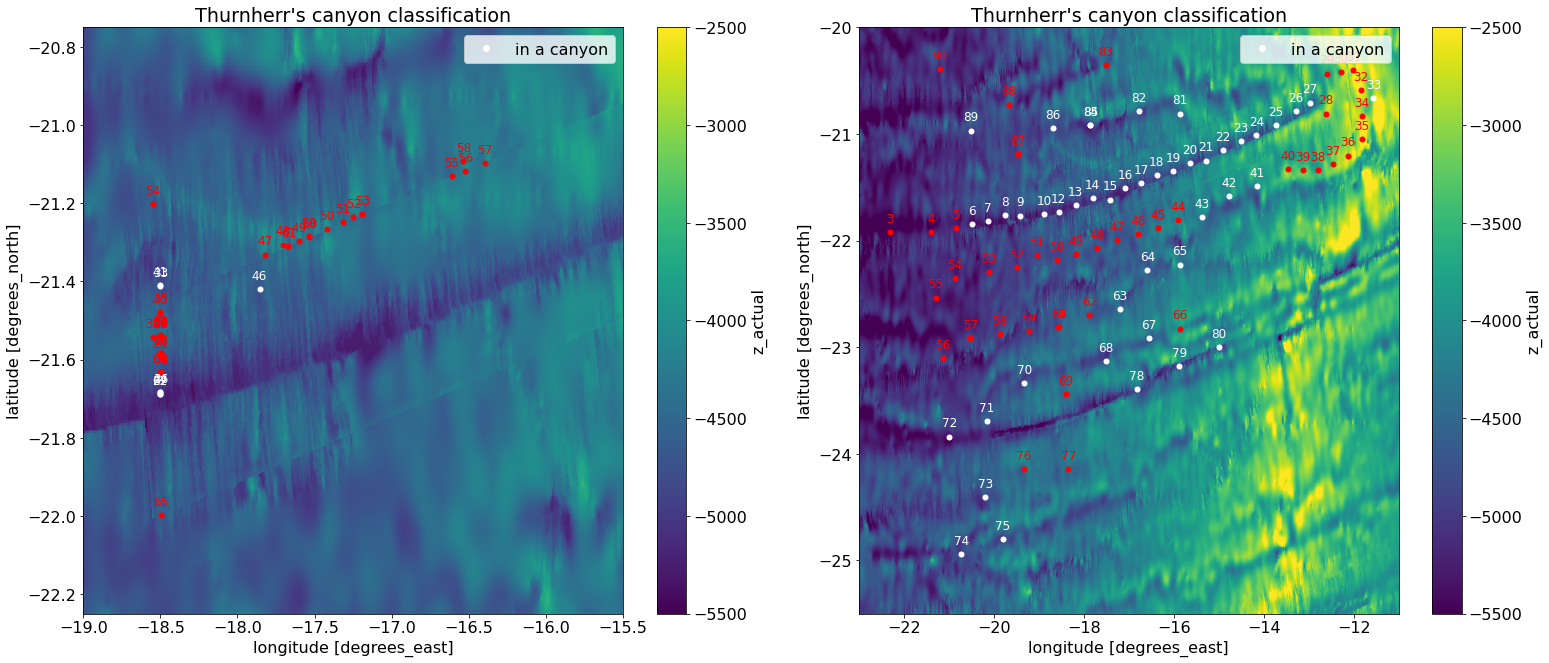

In [19]:
plt.figure(figsize=(22,9.5))

for yi, year in enumerate([1996, 1997]):
    ax = plt.subplot(1,2,yi+1)
    if yi==0:
        q = bathy['z'].sel(lon=slice(-19, -15.5), lat=slice(-22.25, -20.75)).plot(ax=ax,x='lon', y='lat', vmin=-5500, vmax=-2500)
    if yi==1:
        q = bathy['z'].sel(lon=slice(-23, -11), lat=slice(-25.5, -20)).plot(ax=ax,x='lon', y='lat', vmin=-5500, vmax=-2500)
    q.colorbar.remove()
    geo_XY['z_actual'].plot(ax=ax, x='lon', y='lat', vmin=-5500, vmax=-2500)
    for num in np.unique(ndf['castnum']):
        cast = ndf[(ndf['castnum']==num) & (ndf["year"]==year)]
        if len(cast)>0:
            cast=cast.iloc[0]
        else:
            continue
        if cast['latitude'].dtype == 'float64':
            x = cast['longitude']
            y = cast['latitude']
            #if (x<-22) | (x>-10) | (y>-20) | (y<-25): continue
            col='w'
            if np.isnan(cast['canyon']): col='r'
            ax.plot(x, y, color=col, marker="o", markersize=5)
            ax.annotate(np.int(num), # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 fontsize=12,
                 color=col,
                 ha='center'
            )
    plt.plot([],[], "wo", label="in a canyon")
    plt.title("Thurnherr's canyon classification")
    plt.legend()
plt.tight_layout()

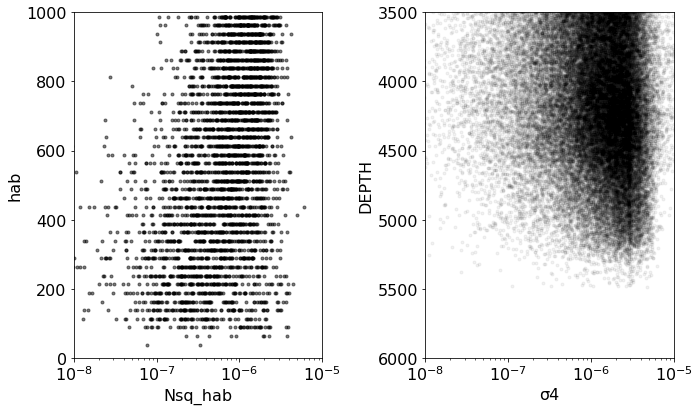

In [20]:
for cast in mds["CAST"]:
    for year in mds["year"]:
        plt.subplot(1,2,1)
        mds['Nsq_hab'].sel(CAST=cast, year=year).plot(y='hab', marker=".", ls="", color="k", alpha=0.5)
        plt.ylim(0, 1000)
        plt.xlim(1e-8, 1e-5)
        plt.xscale("log")
        plt.title("")
        
        plt.subplot(1,2,2)
        (-(g/ρ0)*mds['σ4']).diff("DEPTH").sel(CAST=cast, year=year).plot(y='DEPTH', marker=".", ls="", color="k", alpha=0.05)
        plt.ylim(6000, 3500)
        plt.xlim(1e-8, 1e-5)
        plt.xscale("log")
        plt.title("")
plt.tight_layout()

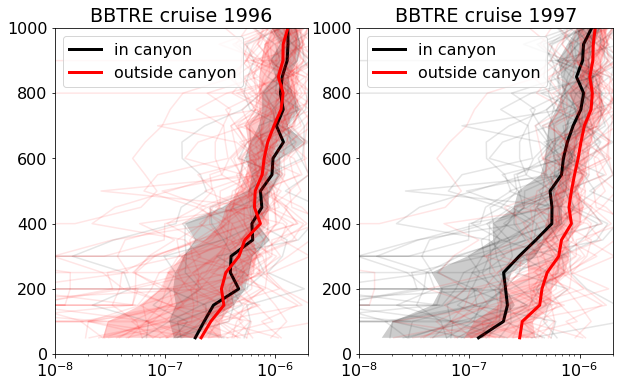

In [21]:
for yi, year in enumerate([1996, 1997], start=1):
    plt.subplot(1,2,yi)
    plt.title(f"BBTRE cruise {year}")
    in_list = np.int64(ndf[~np.isnan(ndf["canyon"]) & (ndf["year"]==year)]["castnum"])
    out_list = np.int64(ndf[np.isnan(ndf["canyon"]) & (ndf["year"]==year)]["castnum"])

    nz = 60
    in_arr = np.ones((nz, len(in_list)))*np.nan
    for i, num in enumerate(in_list):
        if num in cdf['cast number']:
            tmp_df = cdf[cdf['cast number']==num]
            if len(tmp_df)>0:
                pf = tmp_df['pressure_f above bottom']
                plt.plot(tmp_df['Nsq'], pf, "k-", alpha=0.1)
                plt.ylim([0, 1000])
                in_arr[:, i] = tmp_df['Nsq']
    plt.fill_betweenx(pf, np.nanquantile(in_arr,0.25, axis=1), np.nanquantile(in_arr, 0.75, axis=1), facecolor="k", alpha=0.2)
    plt.plot(np.nanmean(in_arr,axis=1), pf, "k-", lw=3, label="in canyon")

    out_arr = np.ones((nz, len(out_list)))*np.nan
    for i, num in enumerate(out_list):
        if num in cdf['cast number']:
            tmp_df = cdf[cdf['cast number']==num]
            if len(tmp_df)>0:
                pf = tmp_df['pressure_f above bottom']
                plt.plot(tmp_df['Nsq'], pf, "r-", alpha=0.1)
                plt.ylim([0, 1000])
                out_arr[:, i] = tmp_df['Nsq']
    plt.fill_betweenx(pf, np.nanquantile(out_arr,0.25, axis=1), np.nanquantile(out_arr,0.75, axis=1), facecolor="r", alpha=0.2)
    plt.plot(np.nanmean(out_arr,axis=1), pf, "r-", lw=3, label="outside canyon")
    plt.xscale("log")
    plt.xlim(1e-8, 2.e-6)
    plt.legend(loc="upper left")

In [22]:
casts = cdf['cast number'].unique()

lons, lats = [], []
for cast in casts:
    lons.append(np.nanmedian(cdf[cdf['cast number']==cast]['longitude'].values))
    lats.append(np.nanmedian(cdf[cdf['cast number']==cast]['latitude'].values))

In [23]:
def global_argmin(da):
    xmin = da.min(dim=['Xr'])
    xargmin = da.argmin(dim='Xr').values
    yargmin = xmin.argmin(dim='Yr').values
    return [xargmin[yargmin], yargmin], xmin[yargmin].values

In [24]:
sample_locs = []
sample_casts = []
sample_coords = []
for c, cast in enumerate(casts):
    if np.isnan(lats[c]) | np.isnan(lons[c]): continue
    mindist = ((geo_XY['lat']-lats[c])**2 + (geo_XY['lon']-lons[c])**2)
    argmin, _ = global_argmin(mindist)
    if (
        (argmin[0] == 0) | (argmin[0] == geo_XY.dims['Xr']-1) |
        (argmin[1] == 0) | (argmin[1] == geo_XY.dims['Yr']-1)
    ):
        print(f"Cast {cast} is outside domain")
        continue
    else:
        print(f"Cast {cast} is inside domain")
    sample_locs.append(argmin)
    sample_coords.append([lons[c], lats[c]])
    sample_casts.append(cast)

Cast 10 is outside domain
Cast 11 is outside domain
Cast 14 is inside domain
Cast 15 is inside domain
Cast 16 is inside domain
Cast 18 is inside domain
Cast 19 is inside domain
Cast 21 is inside domain
Cast 22 is inside domain
Cast 23 is inside domain
Cast 24 is inside domain
Cast 25 is outside domain
Cast 26 is outside domain
Cast 27 is outside domain
Cast 29 is outside domain
Cast 30 is outside domain
Cast 31 is outside domain
Cast 32 is outside domain
Cast 33 is outside domain
Cast 34 is outside domain
Cast 35 is outside domain
Cast 36 is outside domain
Cast 37 is outside domain
Cast 38 is outside domain
Cast 39 is outside domain
Cast 40 is outside domain
Cast 41 is outside domain
Cast 42 is outside domain
Cast 43 is outside domain
Cast 44 is outside domain
Cast 45 is outside domain
Cast 46 is outside domain
Cast 47 is outside domain
Cast 48 is outside domain
Cast 49 is outside domain
Cast 50 is outside domain
Cast 51 is outside domain
Cast 52 is outside domain
Cast 54 is outside do

0, 1, 2, 3, 4, 5, 6, 7, 8, 

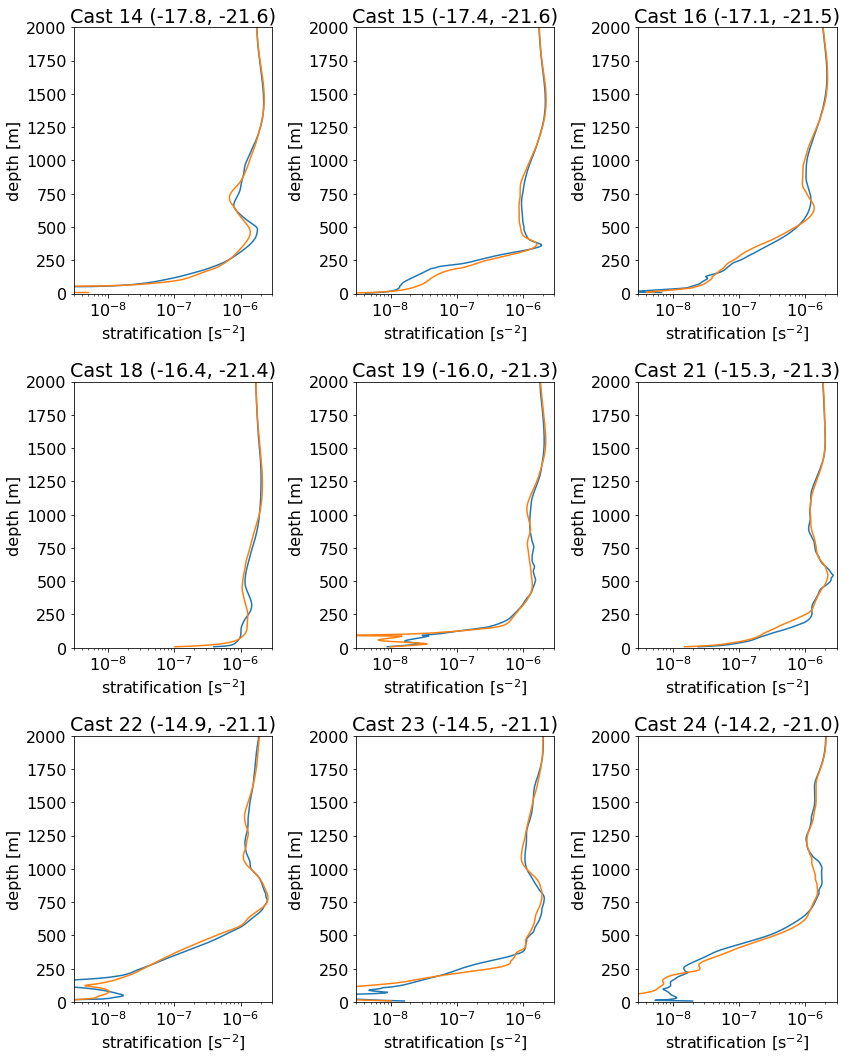

In [25]:
ds['TopographicHeight'] = ds.attrs['H']-ds['Depth']

plt.figure(figsize=(12, 15))

z_obs = -cdf[(cdf['cast number']==sample_casts[0])]['pressure_f above bottom'].values
Nsq_obs_av = np.zeros(z_obs.size)

z_sim = ds['habC'].values
Nsq_sim_av = np.zeros(ds['habC'].size)
Nsq_sim_av2 = np.zeros(ds['habC'].size)

Nsamples = len(sample_casts)

for c, loc in enumerate(sample_locs):
    print(c, end=", ")
    plt.subplot(3,3,c+1)
    
    tmp = ds.isel(XC=loc[0], YC=loc[1])
    Nsq_sim_av += tmp['Nsq_hab'].values/Nsamples
    
    tmp2 = ds2.isel(XC=loc[0], YC=loc[1])
    Nsq_sim_av2 += tmp2['Nsq_hab'].values/Nsamples
    
    plt.semilogx(tmp['Nsq_hab'], tmp['habC'])
    plt.semilogx(tmp2['Nsq_hab'], tmp2['habC'])
    
    tmp_df = cdf[cdf['cast number']==sample_casts[c]]
    Nsq_obs_av += tmp_df['Nsq'].values/Nsamples
    
    plt.semilogx(tmp_df['Nsq'], -tmp_df['pressure_f above bottom'], '--')
    plt.ylim([0, 2000])
    plt.title(f"Cast {sample_casts[c]} ({round(sample_coords[c][0],1)}, {round(sample_coords[c][1],1)})")
    plt.xlim([3.e-9,3.e-6])
    plt.xlabel(r"stratification [s$^{-2}$]")
    plt.ylabel("depth [m]")
    
plt.tight_layout()
#plt.savefig("../../figures/BBTRE/canyon_casts_comparison.png", dpi=150, bbox_inches="tight")

In [28]:
mds = mds.sel(year=1997)

In [29]:
q10 = mds['Nsq_hab'].sel(CAST=np.arange(13, 25)).quantile(0.1, dim="CAST", skipna=True)
q90 = mds['Nsq_hab'].sel(CAST=np.arange(13, 25)).quantile(0.9, dim="CAST", skipna=True)

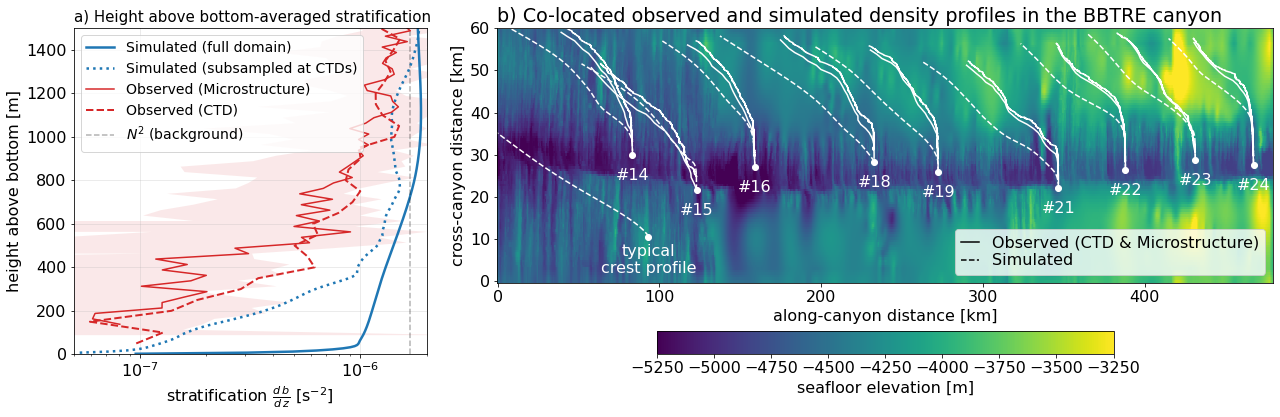

In [36]:
mds_av = mds['Nsq_hab'].sel(CAST=np.arange(13, 25)).mean("CAST", skipna=True)
mds_std = mds['Nsq_hab'].sel(CAST=np.arange(13, 25)).std("CAST", skipna=True)
mask_points = (np.isnan(mds['Nsq_hab'].sel(CAST=np.arange(13, 25))).mean('CAST')) <= 0.5
mds_av = mds_av.where(mask_points)

fig = plt.figure(figsize=(21.5,6))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])

plt.fill_betweenx(mds_av["hab"], q10, q90, alpha=0.1, facecolor="C3")

ds['Nsq_hab_av'].plot(y="habC", xscale="log", lw=2.5, color="C0", linestyle="-", label="Simulated (full domain)")
# ds2['Nsq_hab_av'].plot(y="habC", xscale="log", lw=2., color="C0", linestyle="-", alpha=0.4)

plt.axvline(N**2, alpha=0.3, linestyle="--", color="k")
plt.grid(True, alpha=0.3)

plt.semilogx(Nsq_sim_av, z_sim, "C0:", lw=2.5, label="Simulated (subsampled at CTDs)")
# plt.semilogx(Nsq_sim_av2, z_sim, "C0:", lw=2., alpha=0.4)
# plt.plot([], [], "C0", label=r"Simulated ($2.5 \kappa$)", alpha=0.4)
mds_av.plot(y='hab', color='C3', label="Observed (Microstructure)")
plt.semilogx(Nsq_obs_av, -z_obs, "C3", lw=2., linestyle='--', label="Observed (CTD)")
plt.plot([], [], alpha=0.3, linestyle="--", color="k", label=r"$N^{2}$ (background)")
plt.xlim([5e-8, 2e-6])
plt.ylim([0, 1500])
plt.xlabel(r"stratification $\frac{d\,b}{d\,z}$ [s$^{-2}$]")
plt.ylabel("height above bottom [m]")
plt.legend(loc="upper left", fontsize=14)
plt.title("a) Height above bottom-averaged stratification", fontsize=15, loc="left")
plt.title("")

ax2 = fig.add_subplot(gs[0, 1:])
PC = (geo_XY['z_actual']).plot(cbar_kwargs={'label':"seafloor elevation [m]", "orientation":"horizontal", "fraction":0.07})
PC.set_clim([-5250, -3250])
for c, loc in enumerate(sample_locs):
    x = geo_XY['Xr'].isel(Xr=loc[0]).values
    y = geo_XY['Yr'].isel(Yr=loc[1]).values
    plt.plot(x, y, "wo")
    label = f"#{sample_casts[c]}"
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-25), # distance from text to points (x,y)
                 color='w',
                 ha='center')
    
    # Observed profiles (MICROSTRUCTURE)
    X = mds['σ4'].sel(CAST=sample_casts[c])
    X = (X - X.max(skipna=True))*400e3

    Y = (X.BOT_DEPTH - X.DEPTH)
    X = X.where(Y<1500.)
    Y = Y*2e1
    plt.plot(X+x,Y+y, 'w')
    
    # Observed profiles (CTD)
    tmp = cdf[cdf['cast number']==sample_casts[c]]
    X = tmp['sigma4']
    X = (X - X.max(skipna=True))*400e3

    Y = tmp['pressure above bottom']
    X = X.where(Y<1500.)
    Y = Y*2e1
    plt.plot(X+x,Y+y, 'w')
    
    # Simulated profiles
    X = (ρ0*(1-α*ds.isel(XC=loc[0], YC=loc[1])['THETA_BG_hab']))
    X = (X - X.max(skipna=True))*400e3

    Y = X.habC
    X = X.where(Y<1500.)
    Y = Y*2e1
    plt.plot(X+x,Y+y, 'w--')
    
    
# Outside of canyon example
i=155; j=17;
x = ds['XC'].isel(XC=i).values
y = ds['YC'].isel(YC=j).values
plt.plot(x, y, "wo")
label = f"typical\ncrest profile"
plt.annotate(label, # this is the text
             (x,y), # this is the point to label
             textcoords="offset points", # how to position the text
             xytext=(0,-36), # distance from text to points (x,y)
             color='w',
             ha='center')

X = (ρ0*(1-α*ds.isel(XC=i, YC=j)['THETA_BG_hab']))
X = (X - X.max(skipna=True))*400e3

Y = X.habC
X = X.where(Y<1500.)
Y = Y*2e1
plt.plot(X+x,Y+y, 'w--')

plt.plot([], [], "k-", label="Observed (CTD & Microstructure)")
plt.plot([], [], "k--", label="Simulated")
plt.legend(loc="lower right", labelspacing=0.175, handlelength=1.1)
plt.title("b) Co-located observed and simulated density profiles in the BBTRE canyon", loc="left")
plt.title("")

plt.xlabel("along-canyon distance [km]")
plt.ylabel("cross-canyon distance [km]")
xticks = np.arange(0., 500., 100.)
plt.xticks(xticks*1e3, np.int64(xticks))
yticks = np.arange(0., 70., 10.)
plt.yticks(yticks*1e3, np.int64(yticks))

plt.savefig(f"../../../thesis_defense/figures/D_stratification_comparison.png", dpi=150, bbox_inches="tight")

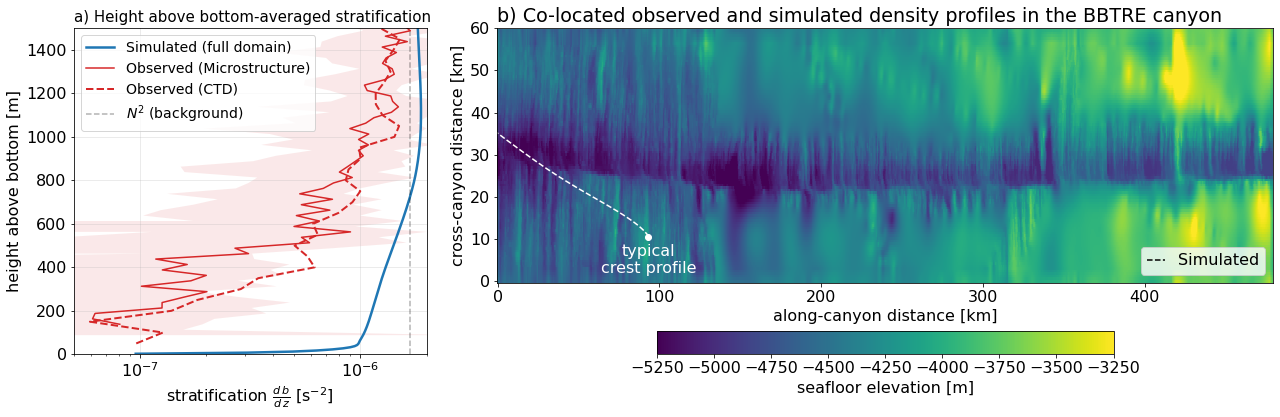

In [38]:
mds_av = mds['Nsq_hab'].sel(CAST=np.arange(13, 25)).mean("CAST", skipna=True)
mds_std = mds['Nsq_hab'].sel(CAST=np.arange(13, 25)).std("CAST", skipna=True)
mask_points = (np.isnan(mds['Nsq_hab'].sel(CAST=np.arange(13, 25))).mean('CAST')) <= 0.5
mds_av = mds_av.where(mask_points)

fig = plt.figure(figsize=(21.5,6))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])

plt.fill_betweenx(mds_av["hab"], q10, q90, alpha=0.1, facecolor="C3")

ds['Nsq_hab_av'].plot(y="habC", xscale="log", lw=2.5, color="C0", linestyle="-", label="Simulated (full domain)")
# ds2['Nsq_hab_av'].plot(y="habC", xscale="log", lw=2., color="C0", linestyle="-", alpha=0.4)

plt.axvline(N**2, alpha=0.3, linestyle="--", color="k")
plt.grid(True, alpha=0.3)

# plt.semilogx(Nsq_sim_av, z_sim, "C0:", lw=2.5, label="Simulated (subsampled at CTDs)")
# plt.semilogx(Nsq_sim_av2, z_sim, "C0:", lw=2., alpha=0.4)
# plt.plot([], [], "C0", label=r"Simulated ($2.5 \kappa$)", alpha=0.4)
mds_av.plot(y='hab', color='C3', label="Observed (Microstructure)")
plt.semilogx(Nsq_obs_av, -z_obs, "C3", lw=2., linestyle='--', label="Observed (CTD)")
plt.plot([], [], alpha=0.3, linestyle="--", color="k", label=r"$N^{2}$ (background)")
plt.xlim([5e-8, 2e-6])
plt.ylim([0, 1500])
plt.xlabel(r"stratification $\frac{d\,b}{d\,z}$ [s$^{-2}$]")
plt.ylabel("height above bottom [m]")
plt.legend(loc="upper left", fontsize=14)
plt.title("a) Height above bottom-averaged stratification", fontsize=15, loc="left")
plt.title("")

ax2 = fig.add_subplot(gs[0, 1:])
PC = (geo_XY['z_actual']).plot(cbar_kwargs={'label':"seafloor elevation [m]", "orientation":"horizontal", "fraction":0.07})
PC.set_clim([-5250, -3250])
# for c, loc in enumerate(sample_locs):
#     x = geo_XY['Xr'].isel(Xr=loc[0]).values
#     y = geo_XY['Yr'].isel(Yr=loc[1]).values
#     plt.plot(x, y, "wo")
#     label = f"#{sample_casts[c]}"
#     plt.annotate(label, # this is the text
#                  (x,y), # this is the point to label
#                  textcoords="offset points", # how to position the text
#                  xytext=(0,-25), # distance from text to points (x,y)
#                  color='w',
#                  ha='center')
    
#     # Observed profiles (MICROSTRUCTURE)
#     X = mds['σ4'].sel(CAST=sample_casts[c])
#     X = (X - X.max(skipna=True))*400e3

#     Y = (X.BOT_DEPTH - X.DEPTH)
#     X = X.where(Y<1500.)
#     Y = Y*2e1
#     plt.plot(X+x,Y+y, 'w')
    
#     # Observed profiles (CTD)
#     tmp = cdf[cdf['cast number']==sample_casts[c]]
#     X = tmp['sigma4']
#     X = (X - X.max(skipna=True))*400e3

#     Y = tmp['pressure above bottom']
#     X = X.where(Y<1500.)
#     Y = Y*2e1
#     plt.plot(X+x,Y+y, 'w')
    
#     # Simulated profiles
#     X = (ρ0*(1-α*ds.isel(XC=loc[0], YC=loc[1])['THETA_BG_hab']))
#     X = (X - X.max(skipna=True))*400e3

#     Y = X.habC
#     X = X.where(Y<1500.)
#     Y = Y*2e1
#     plt.plot(X+x,Y+y, 'w--')
    
    
# Outside of canyon example
i=155; j=17;
x = ds['XC'].isel(XC=i).values
y = ds['YC'].isel(YC=j).values
plt.plot(x, y, "wo")
label = f"typical\ncrest profile"
plt.annotate(label, # this is the text
             (x,y), # this is the point to label
             textcoords="offset points", # how to position the text
             xytext=(0,-36), # distance from text to points (x,y)
             color='w',
             ha='center')

X = (ρ0*(1-α*ds.isel(XC=i, YC=j)['THETA_BG_hab']))
X = (X - X.max(skipna=True))*400e3

Y = X.habC
X = X.where(Y<1500.)
Y = Y*2e1
plt.plot(X+x,Y+y, 'w--')

# plt.plot([], [], "k-", label="Observed (CTD & Microstructure)")
plt.plot([], [], "k--", label="Simulated")
plt.legend(loc="lower right", labelspacing=0.175, handlelength=1.1)
plt.title("b) Co-located observed and simulated density profiles in the BBTRE canyon", loc="left")
plt.title("")

plt.xlabel("along-canyon distance [km]")
plt.ylabel("cross-canyon distance [km]")
xticks = np.arange(0., 500., 100.)
plt.xticks(xticks*1e3, np.int64(xticks))
yticks = np.arange(0., 70., 10.)
plt.yticks(yticks*1e3, np.int64(yticks))

plt.savefig(f"../../../thesis_defense/figures/D_stratification_comparison_before.png", dpi=150, bbox_inches="tight")

In [ ]:
xr.concat([q10, q90], dim="quantile").to_netcdf("../../data/BBTRE-physics/bz_canyon_quantiles.nc")